# Capital One: Bike Data Analysis
## Cleaning and Exploring Data with Pandas
### Author: Sai Yandapalli


**Introduction**

Bike shares are becoming increasingly common in cities in the United States. Commuters have been using bike sharing as a method of transportation for the flexibility, cost savings, exercise, and a myriad of other benefits. While being quite successful, many bike shares are still relatively new and have room for optimization. This is an exploration of some Bike Data from the city of Los Angeles provide by Capital One.

The data exploration will encompass these topics and questions (in order):
* Extracting file contents
* Which start/stop stations are most popular?
* What is the average distance traveled?
* How many riders include bike sharing as a regular part of their commute?
* How does ridership change with seasons?
* What is the breakdown of Trip Route Category-Passholder type combinations? 
    What might make a particular combination more popular?
* Data Visuals


Let's get started!

### 1) Extracting file contents

Reading in the csv, and cleaning our dataframe.

In [22]:
# Setting up imports.
import csv
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import math
import matplotlib.pyplot as plt
from datascience import *
sns.set(style="ticks", color_codes=True)
%matplotlib inline

In [23]:
# Reading our provided data into a dataframe

bikes = pd.read_csv("metro-bike-share-trip-data.csv")
bikes.head()

C:\Users\saiya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
1,1919661,1980,2016-07-07T06:00:00,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
2,1933383,300,2016-07-07T10:32:00,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
3,1944197,10860,2016-07-07T10:37:00,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
4,1940317,420,2016-07-07T12:51:00,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04..."


The dataframe looks formatted pretty well, so not much cleaning is required. However we have no real interpretable information about the stations/locations - just numbers. It's much more meaningful to talk about stations with their actual station name/location, versus "Station 3029". Let's import another dataset with station names, and join the two dataframes.

In [24]:
# Importing stations from https://bikeshare.metro.net/about/data/
stations = pd.read_csv("metro-bike-share-stations-2018-10-19.csv")
stations["Station_ID"] = stations["Station_ID"].astype(float)
stations.head()

,Station_ID,Station_Name,Go_live_date,Region,Status
0,3000.0,Virtual Station,2016-07-07,NaN,Active
1,3005.0,7th & Flower,7/7/2016,DTLA,Active
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active
3,3007.0,5th & Grand,7/7/2016,DTLA,Active
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active


In [25]:
# Joining the tables to get Starting Region and Station Names
bike_joined = bikes.merge(stations[["Station_ID", "Region", "Station_Name"]],
                          left_on = "Starting Station ID", right_on = "Station_ID", how = "left")
bike_filtered = bike_joined.drop(columns = "Station_ID").rename(columns = 
                                                                {"Station_Name":"Starting Station", "Region":"Starting Region"})

# Joining the tables to get Ending Region and Station Names
bike_joined_end = bike_filtered.merge(stations[["Station_ID", "Region", "Station_Name"]], 
                                      left_on = "Ending Station ID", right_on = "Station_ID", how = "left")
bike_data = bike_joined_end.drop(columns = "Station_ID").rename(columns = 
                                                                {"Station_Name":"Ending Station", "Region":"Ending Region"})

# Converting Times to DateTime objects
bike_data["Start Time"] = pd.to_datetime(bike_data['Start Time'])
bike_data["End Time"] = pd.to_datetime(bike_data['End Time'])

bike_data.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long,Starting Region,Starting Station,Ending Region,Ending Station
0,1912818,180,2016-07-07 04:17:00,2016-07-07 04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",DTLA,Union Station West Portal,DTLA,Union Station West Portal
1,1919661,1980,2016-07-07 06:00:00,2016-07-07 06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",DTLA,Union Station West Portal,DTLA,Union Station West Portal
2,1933383,300,2016-07-07 10:32:00,2016-07-07 10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",DTLA,Los Angeles & Temple,DTLA,Los Angeles & Temple
3,1944197,10860,2016-07-07 10:37:00,2016-07-07 13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",DTLA,Los Angeles & Temple,DTLA,Los Angeles & Temple
4,1940317,420,2016-07-07 12:51:00,2016-07-07 12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04...",DTLA,Hope & 6th,DTLA,Hope & 6th


The variables in this data frame are defined as:

Variable       | Description                                                      
-------------- | ------------------------------------------------------
Trip ID | a primary key corresponding to the trip 
Duration | the length of the trip (minutes)
Start Time | the trip start time
End Time | the trip end time 
Starting Station ID | the starting station's unique ID
Starting Station Latitude | the starting station's latitude
Starting Station Longitude | the starting station's latitude
Ending Station ID | the ending station's unique ID
Ending Station Latitude | the ending station's latitude
Ending Station Longitude | the ending station's latitude
Bike ID | The unique bike ID
Plan Duration | The length of that rider's plan
Trip Route Category | Type of trip
Passholder Type | Type of pass the rider has
Starting Lat-Long | Starting latitude and longitude
Ending Lat-Long | Ending latitude and longitude
Starting Region | Region of Start
Starting Station | Name of station of Start
Ending Region | Region of End
Ending Station | Name of station of End

### 2) Which start and stop stations are most popular?

We'll have some visualizations at the end, but first let's check which stations are the most popular. We can do this by checking the number of trips for each unique station. This can be done by grouping by station, and aggregating by count. 

First, let's check the most popular starting station.

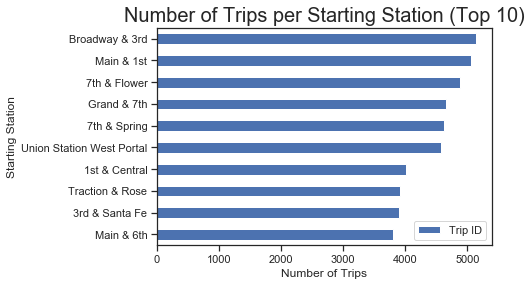

In [26]:
# Grouping by start station
counted_starts = bike_data.groupby("Starting Station").count().sort_values("Bike ID", ascending = False).head(10)

# Making a barplot
ax = counted_starts[["Trip ID"]][::-1].plot.barh()
ax.set(xlabel='Number of Trips', ylabel='Starting Station')
ax = ax.set_title("Number of Trips per Starting Station (Top 10)", fontsize=20)
plt.savefig("images/topstartstations.png", bbox_inches='tight', dpi=300);

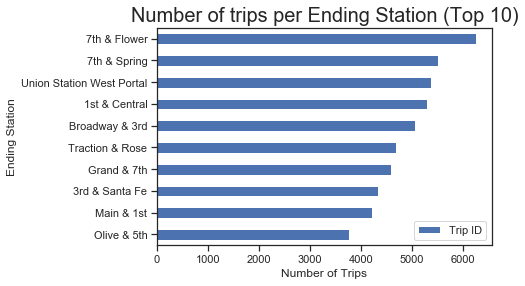

In [27]:
# Grouping by start station
counted_ends = bike_data.groupby("Ending Station").count().sort_values("Bike ID", ascending = False).head(10)

# Making a barplot

ax = counted_ends[["Trip ID"]][::-1].plot.barh()
ax.set(xlabel='Number of Trips', ylabel='Ending Station')
ax = ax.set_title("Number of trips per Ending Station (Top 10)", fontsize=20)
plt.savefig("images/topendstations.png", bbox_inches='tight', dpi=300);

It seems Broadway & 3rd is our top Starting Station and 7th & Flower is our top ending station. Also, a lot of these stations are duplicated - they are just popular stations. Let's visualize some of these stations on a map.

In [28]:
#Making a top starts dataframe with all of the information
top_starts = bike_data[bike_data["Starting Station"].isin(counted_ends.index)].groupby("Starting Station").first()
top_starts = top_starts[['Starting Station Latitude', 'Starting Station Longitude']].reset_index()
top_starts = top_starts.rename(columns = 
                    {"Starting Station Latitude":"lat", "Starting Station Longitude":"long", "Starting Station":"name"})

#Converting to dataframe
t = Table().with_columns([
"lat", top_starts["lat"], 
"lon", top_starts["long"], 
"name", top_starts["name"]
])
Marker.map_table(t)

C:\Users\saiya\Anaconda3\lib\site-packages\datascience\maps.py:368: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
  f(**self._folium_kwargs)


We can see that the top (starting) stations, and subsequently most of our top ending stations are in the Financial District, and Little Tokyo!

### 3) What is the average distance traveled?

We can find this by calculating the distances between all start lat/long and all end lat/long and adding this as a column to our dataframe. Then, we can just take the mean of this column.

In [29]:
# Function taken from coldspeed at StackOverflow.

# Returns the distance in meters between two points.
def get_distance(lat_1, lng_1, lat_2, lng_2): 
    d_lat = lat_2 - lat_1
    d_lng = lng_2 - lng_1 

    temp = (  
         math.sin(d_lat / 2) ** 2 
       + math.cos(lat_1) 
       * math.cos(lat_2) 
       * math.sin(d_lng / 2) ** 2
    )

    return 6373.0 * (2 * math.atan2(math.sqrt(temp), math.sqrt(1 - temp))) * 1000

# A series of distances for each lat and long for start & ends.
distances = pd.Series(map(get_distance,bike_data["Starting Station Latitude"],
                          bike_data["Starting Station Longitude"],
                          bike_data["Ending Station Latitude"],
                          bike_data["Ending Station Longitude"]))

# Adding this to the table and finding our value.
bike_data["Trip Distance"] = round(distances, 2)
mean_distance = np.mean(distances.dropna())

# Printing
print("The average distance is " + str(round(mean_distance, 2)) + " meters.")

The average distance is 66738.32 meters.


### 4) How many riders include bike sharing as a regular part of their commute?

We can assume each rider that commutes will be having 10 regular rides per week (to work and to home). We can start by filtering our dataframe to rides that occur on the same weekday, different destinations per trip (since we are either going to work or to home from the respective opposite), and the trip start and end times are either within valid "to work" hours (4AM-11AM), or valid "to home" hours (4PM-11PM). Then, since with our assumption each rider is representing 10 different trips per work week, we can count the number of commute trips and divide by 10.

In [30]:
# Converting to Days
bike_data["Start Day"] = bike_data['Start Time'].dt.day_name()
bike_data["End Day"] = bike_data['End Time'].dt.day_name()

# Checking if trip is on same weekday
samedaycommute = pd.Series(x == y and x in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"] 
                           for x,y in zip(bike_data['Start Day'],bike_data['End Day']))

# Checking if Start and End are different stations
diffdestinations = bike_data['Starting Station ID'].values != bike_data['Ending Station ID']

# Checking if the trip is either in a valid "to work" time (4am - 10am) or a valid "to home" time (4pm - 10pm)
isworkingtime = pd.Series(((4<=x and x<=10) and (4<=y and y<=10)) or 
                          ((15<=x and x<=22) and (15<=y and y<=22)) 
                          for x,y in zip(bike_data['Start Time'].dt.hour, bike_data['End Time'].dt.hour))

# Combining and adding to the table
isCommuteTrip = diffdestinations & isworkingtime & samedaycommute
bike_data["Commute"] = isCommuteTrip

print("The total amount of trips that count as a commute trip is " + str(sum(isCommuteTrip)) + " (under our assumptions).")

The total amount of trips that count as a commute trip is 61423 (under our assumptions).


So, since with our assumption each rider is representing $10$ average commute trips per work week, there are $61423$ trips (we classified as a commute) divided by $10$ trips per rider on average, so about $6142$ riders include bike sharing as a regular part of their commute! 

Let's visualize the distribution of starting times for same-day weekday trips (where the start and end destination are not the same).

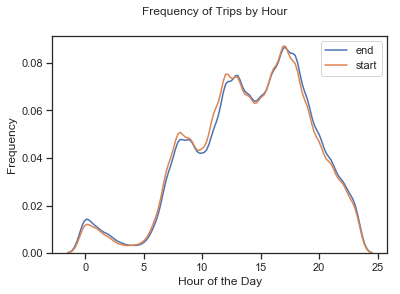

In [31]:
# Setting up and plotting
sns.distplot(bike_data["End Time"].dt.hour, hist = False, label="end")
ax = sns.distplot(bike_data["Start Time"].dt.hour, hist = False, label="start")
plt.suptitle("Frequency of Trips by Hour")
ax.set(xlabel='Hour of the Day', ylabel='Frequency')
plt.savefig("images/freqbyhour1.png", bbox_inches='tight', dpi=300)

There are clearly two peaks at around the morning and evening (from home to work, and work to home respectively). We can ignore the peak in the middle because the data we are using did not filter out specifically commutes (so these could be just casual bikers).

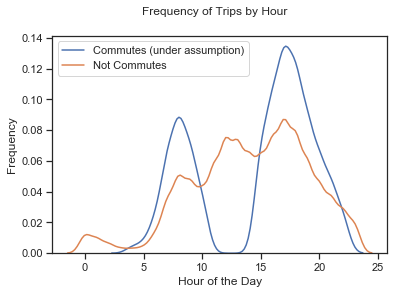

In [32]:
# Setting up and plotting
sameDaydiffLoc2 = diffdestinations & samedaycommute & isworkingtime
sns.distplot(bike_data[sameDaydiffLoc2]["Start Time"].dt.hour, hist = False, label="Commutes (under assumption)")
ax = sns.distplot(bike_data["Start Time"].dt.hour, hist = False, label="Not Commutes")
plt.suptitle("Frequency of Trips by Hour")
ax.set(xlabel='Hour of the Day', ylabel='Frequency')
plt.savefig("images/freqbyhour1=2.png", bbox_inches='tight', dpi=300);

Our assumptions helped to capture only the rides that fit into a workday commute, when overlaid with the distribution of all rides.

### 5) How does ridership change with season?

Let's find the season for each of the trips, and then graph the distribution of trips per season! We will define the month ranges of seasons as defined in https://www.timeanddate.com/calendar/aboutseasons.html.

In [33]:
# Building mapper function
def find_season(datetime):
    if 3 <= datetime.month and datetime.month <= 5:
        return "Spring"
    elif 6 <= datetime.month and datetime.month<= 8:
        return "Summer"
    elif 9 <= datetime.month and datetime.month<= 11:
        return "Fall"
    elif 12 == datetime.month or datetime.month <= 2:
        return "Winter"

# Mapping function
seasons = pd.Series(map(find_season,bike_data["Start Time"]))
bike_data["Season"] = seasons

Let's use the seasons to check the average trip duration per season

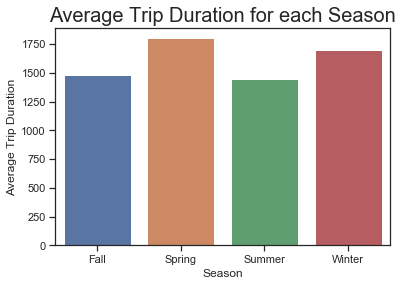

In [34]:
# Grouping
duration_means = bike_data.groupby("Season").mean()[["Duration"]]

# Plotting
ax = sns.barplot(duration_means.index, duration_means['Duration'], data = duration_means)
ax.set(xlabel='Season', ylabel='Average Trip Duration')
ax = ax.set_title("Average Trip Duration for each Season", fontsize=20)
plt.savefig("images/avgtripdurationseason.png", bbox_inches='tight', dpi=300);

It seems like summers have the shortest trips on average! Let's explore the pass types per season.

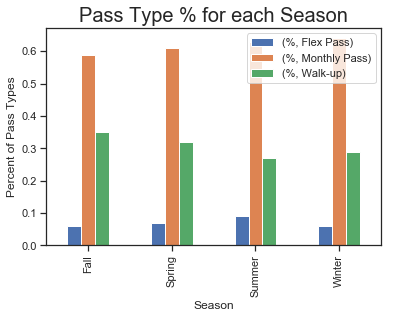

In [35]:
pass_types = bike_data[~bike_data["Passholder Type"]
                       .isin(["Staff Annual"])].groupby(["Season", "Passholder Type"]).count()[['Duration']]
pass_types["%"] = pass_types.groupby(level=0).transform(lambda x: (x / x.sum()).round(2))
ax = pass_types[["%"]].unstack().plot(kind='bar', stacked=False)
a = ax.legend(title= "")
ax.set(xlabel='Season', ylabel='Percent of Pass Types')
ax = ax.set_title("Pass Type % for each Season", fontsize=20)
plt.savefig("images/passtypeseason.png", bbox_inches='tight', dpi=300);

It looks like Fall has a higher percentage of walk-ups, and winter has a higher percentage of monthly passes.

### What is the breakdown of Trip Route Category-Passholder type combinations? What might make a particular combination more popular?

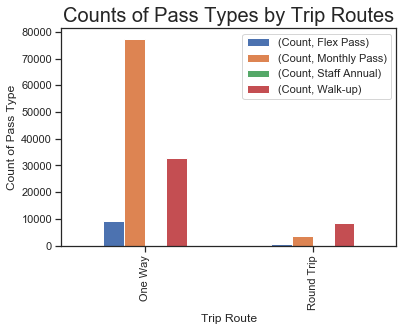

In [36]:
# Making a joint table
joint = bike_data.groupby(["Trip Route Category", "Passholder Type"]).count()[["Trip ID"]].rename(columns={"Trip ID": "Count"})

# Graphing the bar Plot
ax = joint[["Count"]].unstack().plot(kind='bar', stacked=False)
a = ax.legend(title= "")
ax.set(xlabel='Trip Route', ylabel='Count of Pass Type')
ax = ax.set_title("Counts of Pass Types by Trip Routes", fontsize=20)
plt.savefig("images/passroute.png", bbox_inches='tight', dpi=300);

It's clear that the Flex Pass is almost non-existent in users that go on round trips! Something that could make this combination much more popular is, if you have the Flex Pass, round trips are heavily discounted (or maybe signing up for a free pass enables you for X amount of free round trips). This would target this market, and make Flex passes more alluring for those that go on round trips. In the long run, the not many (clearly) even go on round trips, so this is still profitable from the sales perspective.

### 6) Data Visuals

Let's visualize some stuff!

Let's view the different places by how many times it is used as a starting location.

In [37]:
# Grouping by start station
counted_starts2 = bike_data.groupby("Starting Station").count().sort_values("Bike ID", ascending = False)

#Making a top starts dataframe with all of the information
top_starts = bike_data[bike_data["Starting Station"].isin(counted_starts2.index)].groupby("Starting Station").first()
top_starts = top_starts[['Starting Station Latitude', 'Starting Station Longitude']].reset_index()
top_starts = top_starts.rename(columns = {"Starting Station Latitude":"lat",
                                          "Starting Station Longitude":"long",
                                          "Starting Station":"name"})

#Converting to dataframe
t = Table().with_columns([
"lat", top_starts["lat"], 
"lon", top_starts["long"], 
"name", top_starts["name"],
"color", "blue",
"area", counted_starts2["Duration"]*100
])
Circle.map_table(t)

C:\Users\saiya\Anaconda3\lib\site-packages\datascience\maps.py:368: FutureWarning: circle_marker is deprecated. Use add_children(CircleMarker) instead
  f(**self._folium_kwargs)


Let's visualize the average duration per passholder type!

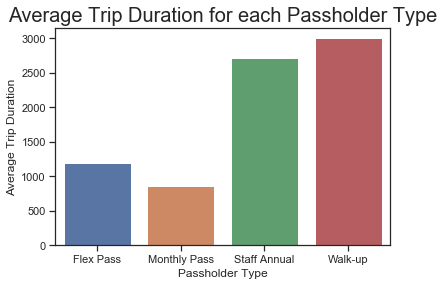

In [38]:
# Grouping
duration_means = bike_data.groupby("Passholder Type").mean()[["Duration"]]

# Plotting
ax = sns.barplot(duration_means.index, duration_means['Duration'], data = duration_means)
ax.set(xlabel='Passholder Type', ylabel='Average Trip Duration')
ax = ax.set_title("Average Trip Duration for each Passholder Type", fontsize=20)
plt.savefig("images/avgtrippassholdertype.png", bbox_inches='tight', dpi=300);

Looks like the walk up and staff annual passholders take much longer trips than the more regular riders!

Let's look at the most used bike, and the locations it's been to.

In [39]:
# Grouping by bike
counted_bikes = bike_data.groupby("Bike ID").count().sort_values("Duration", ascending = False)[["Duration"]]
counted_bikes.iloc[0]

Duration    312
Name: 4727.0, dtype: int64

Bike 4720 has had 312 trips! Let's see where it has been.

In [40]:
# Grouping by start station
counted_starts2 = bike_data[bike_data["Bike ID"] == 4727.0].groupby("Starting Station").count().sort_values("Bike ID", ascending = False)

#Making a top starts dataframe with all of the information
top_starts = bike_data[bike_data["Starting Station"].isin(counted_starts2.index)].groupby("Starting Station").first()
top_starts = top_starts[['Starting Station Latitude', 'Starting Station Longitude']].reset_index()
top_starts = top_starts.rename(columns = {"Starting Station Latitude":"lat", "Starting Station Longitude":"long", 
                                          "Starting Station":"name"})

#Converting to dataframe
t = Table().with_columns([
"lat", top_starts["lat"], 
"lon", top_starts["long"], 
"name", top_starts["name"],
])
Marker.map_table(t)

C:\Users\saiya\Anaconda3\lib\site-packages\datascience\maps.py:368: FutureWarning: simple_marker is deprecated. Use add_children(Marker) instead
  f(**self._folium_kwargs)


In [41]:
print("Bike 4727 has been to " + str(round((t.num_rows / len(bike_data["Starting Station"].unique()))*100, 2))
      + " percent of Downtown LA Stations!")

Bike 4727 has been to 81.82 percent of Downtown LA Stations!
